### Coin-prediction

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [3]:
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


In [5]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [6]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


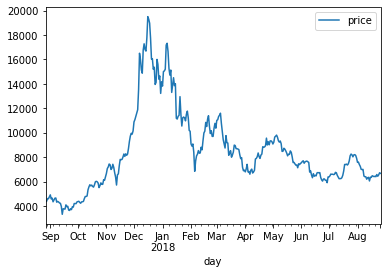

In [7]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Sat, 12 Jun 2021   AIC                           5587.107
Time:                        16:55:43   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3726     27.794      0.229      0.819     -48.103      60.848
ar.L1.D.y     -0.3789      1.828     -0.207      0.836      -3.961       3.204
ar.L2.D.y      0.1585      1.191      0.133      0.8

<AxesSubplot:>

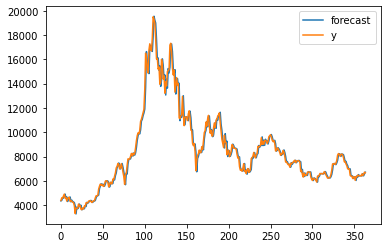

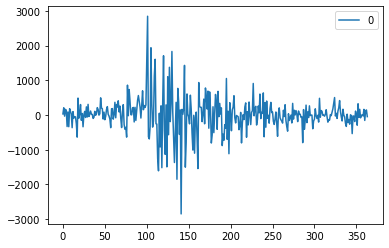

In [9]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

In [10]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

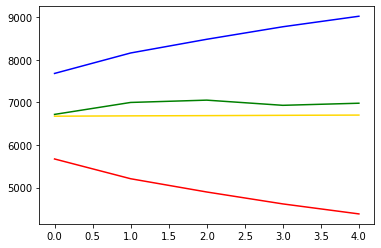

In [11]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

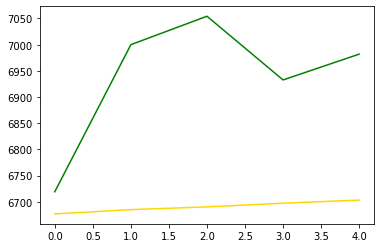

In [12]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

270.69060314623266


In [15]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [16]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [17]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [18]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,743.945954,6341.039780,7655.512696,743.945954,743.945954,9.701373,9.701373,9.701373,8.394624,...,-0.006208,-0.006208,-0.006208,-1.300542,-1.300542,-1.300542,0.0,0.0,0.0,6989.092566
366,2018-08-28,747.992792,6421.782370,7788.934077,747.992792,747.992792,9.701373,9.701373,9.701373,8.493179,...,0.013816,0.013816,0.013816,-1.222010,-1.222010,-1.222010,0.0,0.0,0.0,7100.829613
367,2018-08-29,752.039630,6478.130685,7846.058594,751.995695,752.070698,9.701373,9.701373,9.701373,8.502794,...,-0.041245,-0.041245,-0.041245,-1.157333,-1.157333,-1.157333,0.0,0.0,0.0,7146.477986
368,2018-08-30,756.086468,6535.642845,7950.894445,749.744798,763.646578,9.701373,9.701373,9.701373,8.581520,...,-0.009707,-0.009707,-0.009707,-1.110146,-1.110146,-1.110146,0.0,0.0,0.0,7244.457686
369,2018-08-31,760.133306,6565.588919,8152.364245,743.367894,779.818873,9.701373,9.701373,9.701373,8.652744,...,0.034959,0.034959,0.034959,-1.083588,-1.083588,-1.083588,0.0,0.0,0.0,7337.371987


In [19]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6989.092566,6341.039780,7655.512696
366,2018-08-28,7100.829613,6421.782370,7788.934077
367,2018-08-29,7146.477986,6478.130685,7846.058594
368,2018-08-30,7244.457686,6535.642845,7950.894445
369,2018-08-31,7337.371987,6565.588919,8152.364245


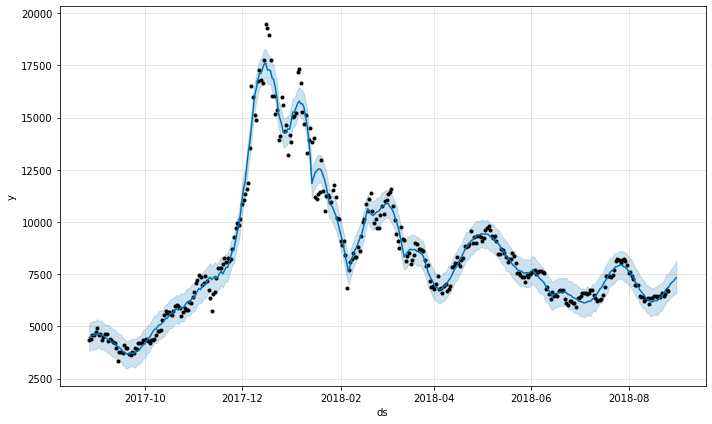

In [20]:
fig1 = prophet.plot(forecast_data)

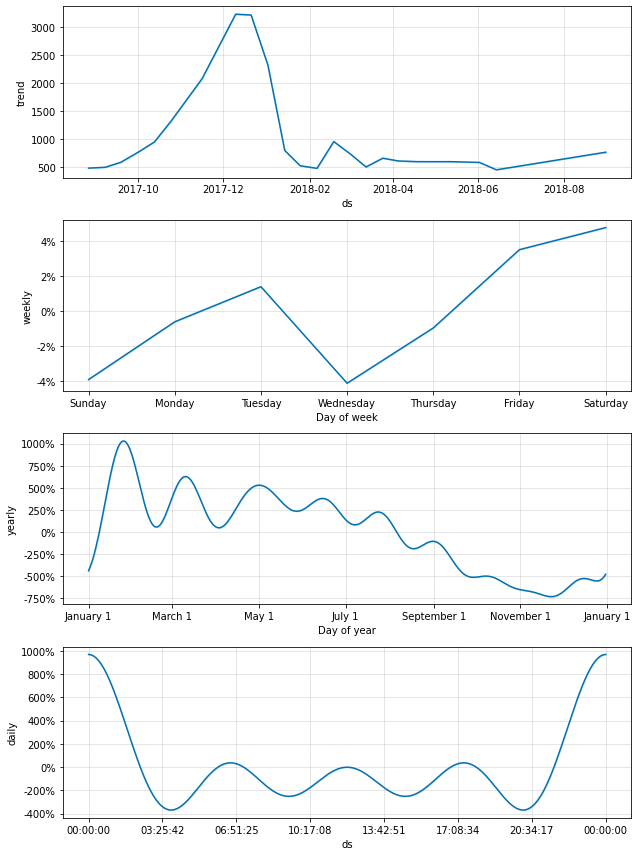

In [21]:
fig2 = prophet.plot_components(forecast_data)

In [22]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [23]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

523.7407372050384
0.9736327901164454


In [24]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

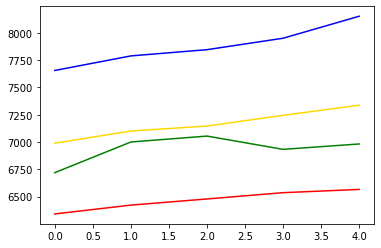

In [25]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

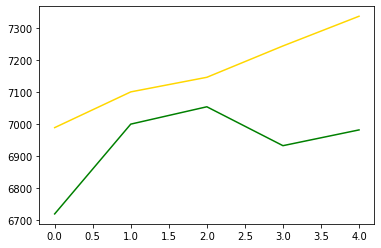

In [26]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [27]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

251.0018833349742
